## MODEL TRAINING

In [1]:
# ct_liver_seg.ipynb
# train a semantic segmentation model to predict the liver & tumor region in CT volume
#
# author  : xiao deng
# date    : 20210613
# platform: Macbook pro 14

import os
import random

import numpy as np
from scipy.ndimage import zoom
from rich.progress import track
import matplotlib.pyplot as plt


# 1) Load CT scans and corresponding masks
# file name format: {series_uid}_{slice_index}.npy
# series ids: 0~49, 50 CT scans in total
ct_dir = 'images'
mask_dir = 'labels'
file_names = os.listdir(ct_dir)

images = {}
masks = {}
for file_name in track(file_names, 'Load & preprocess data ...'):
    series_uid = int(file_name[:3])
    slice_index = int(file_name[4:7])
    
    # 2) CT image preprocessing
    # Load image
    image = np.load(f'{ct_dir}/{file_name}')
    mask = np.load(f'{mask_dir}/{file_name}')
    
    # Resizing
    # image size: 512*512 -> 256*256
    image = zoom(image, 0.5, mode='nearest')
    mask = zoom(mask, 0.5, mode='nearest')
    image = image.astype('float32')
    
    # Split and binarize masks
    liver_mask = np.where(mask > 0, 1, 0).astype('float32')
    tumor_mask = np.where(mask > 1, 1, 0).astype('float32')
    mask = np.zeros((256, 256, 2), dtype='float32')
    mask[:, :, 0] = liver_mask
    mask[:, :, 1] = tumor_mask
    
    # CT windowing (Liver window adjustment)
    # ref: https://radiopaedia.org/articles/windowing-ct
    liver_wind_upper_bound = 180
    liver_wind_lower_bound = -120
    image[image > liver_wind_upper_bound] = liver_wind_upper_bound
    image[image < liver_wind_lower_bound] = liver_wind_lower_bound
    
    # Min-max normalization
    image = (image - liver_wind_lower_bound) / (liver_wind_upper_bound - liver_wind_lower_bound)
    
    if series_uid not in images:
        images[series_uid] = []
        masks[series_uid] = []
    images[series_uid].append(image)
    masks[series_uid].append(mask)

Output()

In [2]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


# 3) Init mixed precision
# TF warning: No compute capability with METAL, turn it off
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# 4) Split training & validation set
series_uids = list(range(50))

seed = 0
random.Random(seed).shuffle(series_uids)

train_ratio = 0.8
idx_t = int(len(series_uids) * train_ratio)
train_series_uids = series_uids[:idx_t]
valid_series_uids = series_uids[idx_t:]
train_x = [image for series_uid in train_series_uids for image in images[series_uid]]
train_y = [mask for series_uid in train_series_uids for mask in masks[series_uid]]
valid_x = [image for series_uid in valid_series_uids for image in images[series_uid]]
valid_y = [mask for series_uid in valid_series_uids for mask in masks[series_uid]]

# reshape, channel last
train_x = np.array([np.expand_dims(image, axis=2) for image in train_x])
train_y = np.array([mask for mask in train_y])
valid_x = np.array([np.expand_dims(image, axis=2) for image in valid_x])
valid_y = np.array([mask for mask in valid_y])

print(f'train series uids: {train_series_uids}')
print(f'valid series uids: {valid_series_uids}\n')
print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'valid_x shape: {valid_x.shape}')
print(f'valid_y shape: {valid_y.shape}')

# 5) Build 2D semantic segmentation model in TF
# define customized loss function and metric to calculate the overlapping region between ground truth and pred
# dice format: 2*|A⋂B|/|A+B|
def dice_coefficient(true, pred, smooth=1e-3):
    true_f = K.flatten(true)
    pred_f = K.flatten(pred)
    intersection = K.sum(true_f * pred_f)
    return (2. * intersection + smooth) / (K.sum(true_f) + K.sum(pred_f) + smooth)


def dice_coefficient_loss(true, pred):
    return -dice_coefficient(true, pred)

# create a classic 2D 6-layer unet which is a common but powerful model architecture for biomedical image segmentation
# ref: extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Farxiv.org%2Fpdf%2F1505.04597.pdf
# apply orthogonal initializer to get better initial weights to push convergence start
# replace Conv2DTranspose to UpSampling2D, in my experience, the latter wound converge slower but get better performance
input_shape = (256, 256, 1)
initializer = 'orthogonal'

inputs = Input(input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv5)

# up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv6)

# up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv7)

# up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv8)

# up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(conv9)

conv10 = Conv2D(2, (1, 1), activation='sigmoid', kernel_initializer=initializer)(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

init_lr = 1e-4
model.compile(
    loss=dice_coefficient_loss,
    optimizer=Adam(learning_rate=init_lr),
    metrics=[dice_coefficient]
)

model.summary()

# 6) Fit the training data
callbacks = [TensorBoard(log_dir="logs"),
             EarlyStopping(monitor='val_loss', patience=7),  # prevent overfitting
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_lr=init_lr/100)]

model.fit(
    train_x,
    train_y,
    batch_size=16,
    validation_data=(valid_x, valid_y),
    epochs=80,
    callbacks=callbacks
)

model.save('liver_seg.h5')

train series uids: [43, 1, 28, 14, 36, 12, 0, 27, 47, 7, 33, 34, 20, 49, 5, 38, 11, 23, 40, 15, 10, 21, 46, 3, 9, 4, 41, 42, 39, 17, 29, 45, 6, 35, 18, 8, 44, 13, 37, 22]
valid series uids: [30, 19, 25, 31, 32, 16, 2, 26, 48, 24]

train_x shape: (1160, 256, 256, 1)
train_y shape: (1160, 256, 256, 2)
valid_x shape: (290, 256, 256, 1)
valid_y shape: (290, 256, 256, 2)
Metal device set to: Apple M1 Pro


2022-06-15 12:33:14.407365: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-15 12:33:14.407462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Total params: 7,846,114
Trainable params: 7,846,114
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/80


2022-06-15 12:33:15.292911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-15 12:33:15.861524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - ETA: 0s - loss: -0.1532 - dice_coefficient: 0.1532

2022-06-15 12:34:11.765782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - 60s 812ms/step - loss: -0.1532 - dice_coefficient: 0.1532 - val_loss: -0.1691 - val_dice_coefficient: 0.1703 - lr: 1.0000e-04
Epoch 2/80
73/73 [==============================] - 59s 802ms/step - loss: -0.6356 - dice_coefficient: 0.6373 - val_loss: -0.8789 - val_dice_coefficient: 0.8803 - lr: 1.0000e-04
Epoch 3/80
73/73 [==============================] - 59s 805ms/step - loss: -0.9041 - dice_coefficient: 0.9042 - val_loss: -0.9250 - val_dice_coefficient: 0.9261 - lr: 1.0000e-04
Epoch 4/80
73/73 [==============================] - 59s 806ms/step - loss: -0.9230 - dice_coefficient: 0.9231 - val_loss: -0.9385 - val_dice_coefficient: 0.9396 - lr: 1.0000e-04
Epoch 5/80
73/73 [==============================] - 59s 802ms/step - loss: -0.9453 - dice_coefficient: 0.9454 - val_loss: -0.9506 - val_dice_coefficient: 0.9512 - lr: 1.0000e-04
Epoch 6/80
73/73 [==============================] - 58s 800ms/step - loss: -0.9520 - dice_coefficient: 0.9519 - val_loss:

Epoch 46/80
73/73 [==============================] - 58s 801ms/step - loss: -0.9887 - dice_coefficient: 0.9887 - val_loss: -0.9888 - val_dice_coefficient: 0.9889 - lr: 2.0000e-05
Epoch 47/80
73/73 [==============================] - 62s 851ms/step - loss: -0.9887 - dice_coefficient: 0.9887 - val_loss: -0.9889 - val_dice_coefficient: 0.9890 - lr: 2.0000e-05
Epoch 48/80
73/73 [==============================] - 59s 807ms/step - loss: -0.9887 - dice_coefficient: 0.9887 - val_loss: -0.9889 - val_dice_coefficient: 0.9890 - lr: 2.0000e-05
Epoch 49/80
73/73 [==============================] - 59s 811ms/step - loss: -0.9887 - dice_coefficient: 0.9888 - val_loss: -0.9890 - val_dice_coefficient: 0.9891 - lr: 2.0000e-05
Epoch 50/80
73/73 [==============================] - 59s 814ms/step - loss: -0.9887 - dice_coefficient: 0.9887 - val_loss: -0.9890 - val_dice_coefficient: 0.9891 - lr: 2.0000e-05
Epoch 51/80
73/73 [==============================] - 60s 816ms/step - loss: -0.9886 - dice_coefficient: 0

## MODEL EVALUATION

10/10 [==============================] - 4s 382ms/step
Mean dice of liver: 0.925000011920929
Mean dice of tumor: 0.3788965344429016
slice id: 0


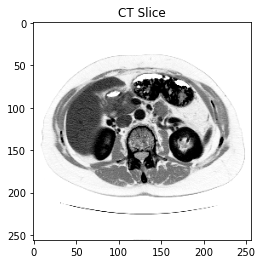

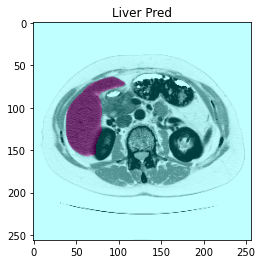

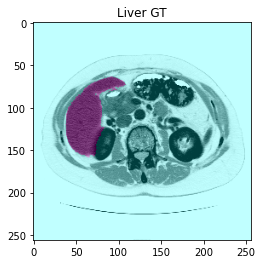

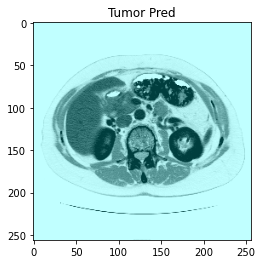

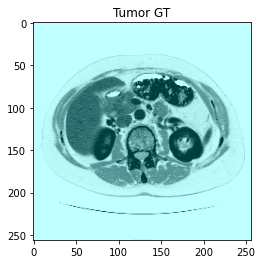

slice id: 1


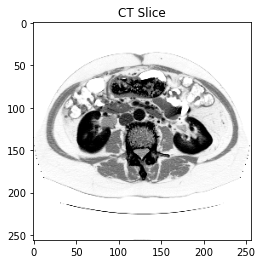

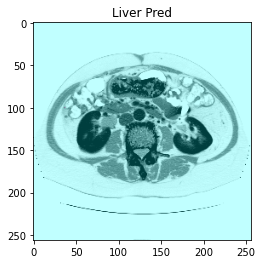

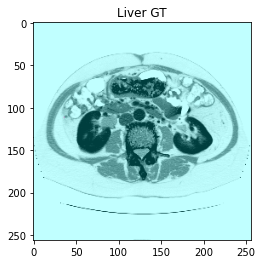

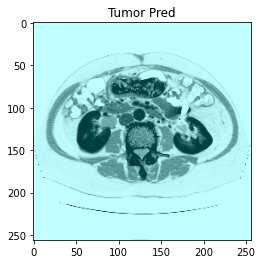

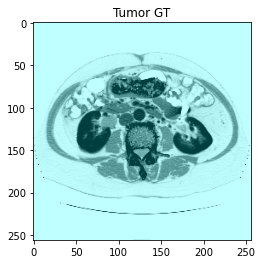

slice id: 2


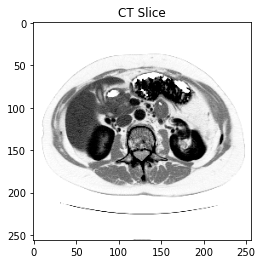

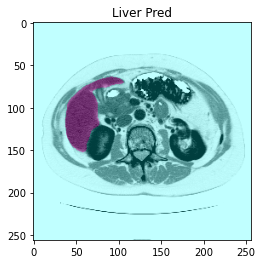

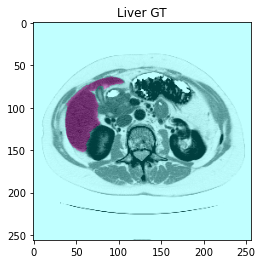

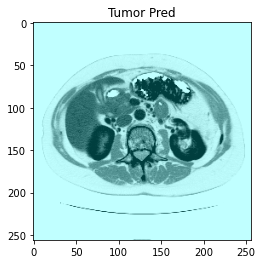

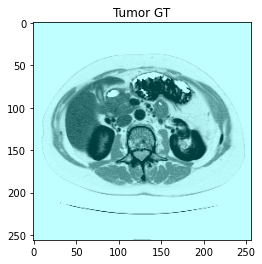

slice id: 3


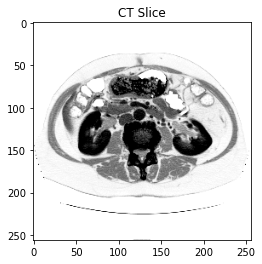

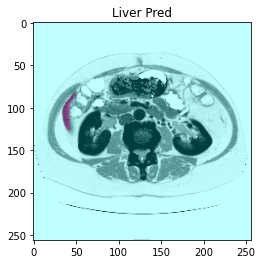

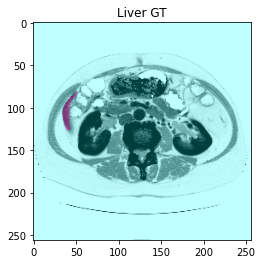

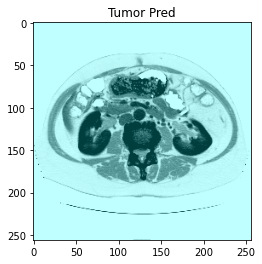

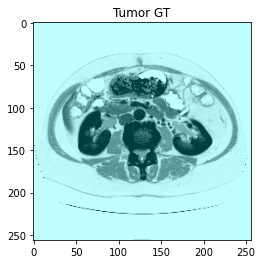

slice id: 4


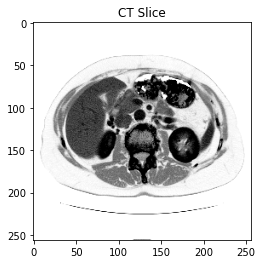

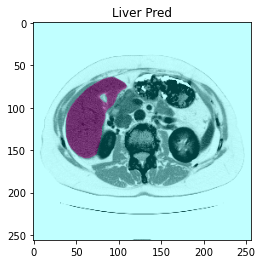

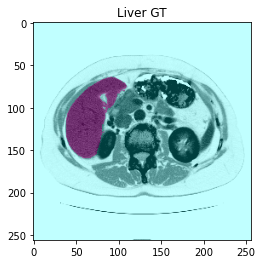

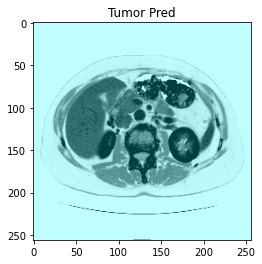

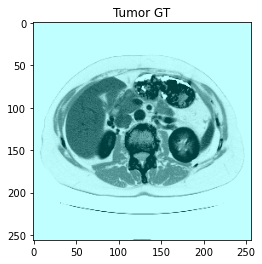

slice id: 5


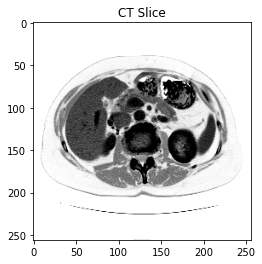

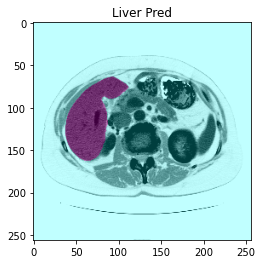

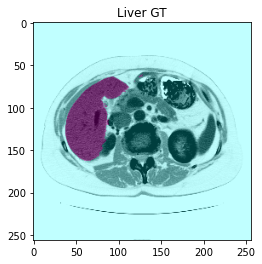

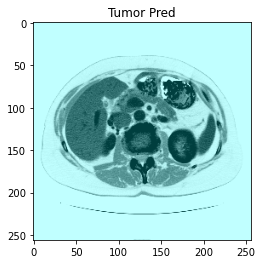

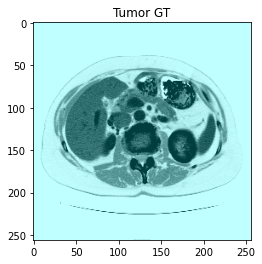

slice id: 6


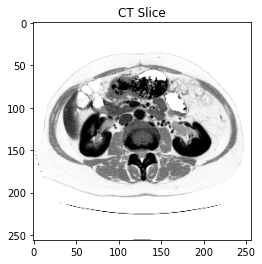

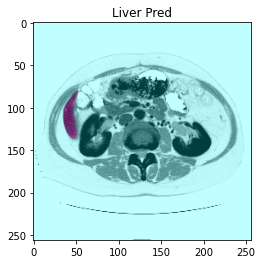

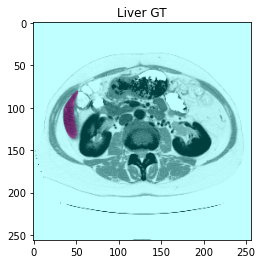

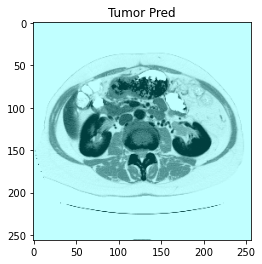

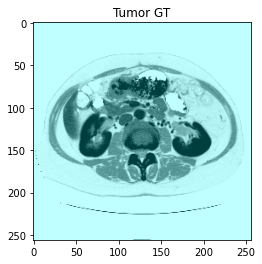

slice id: 7


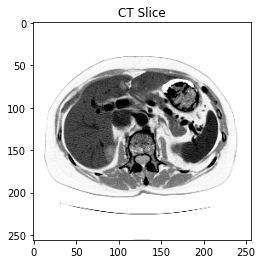

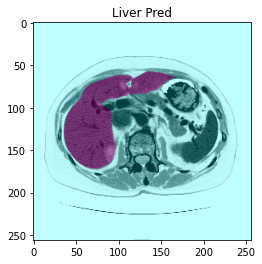

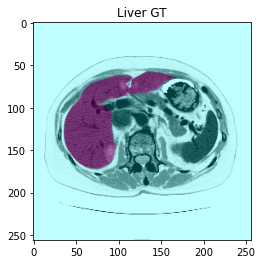

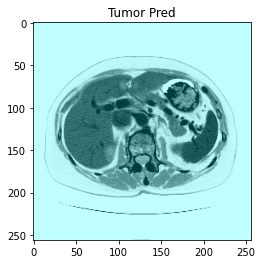

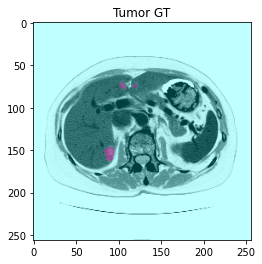

slice id: 8


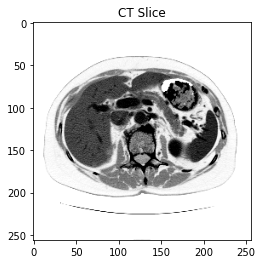

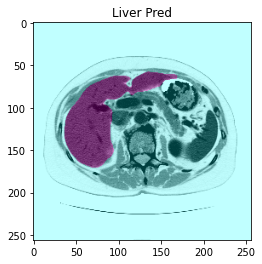

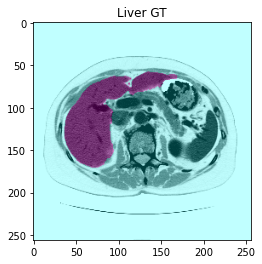

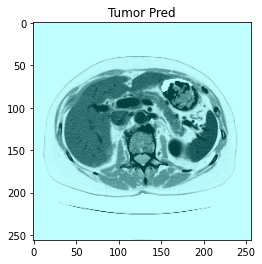

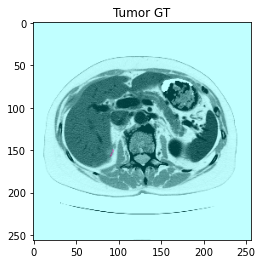

slice id: 9


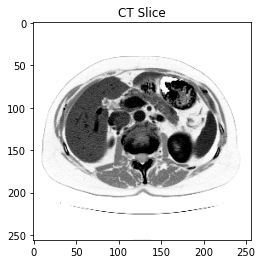

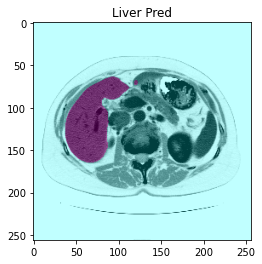

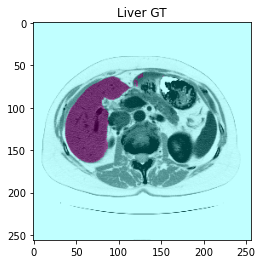

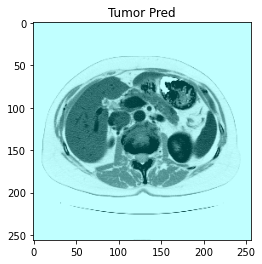

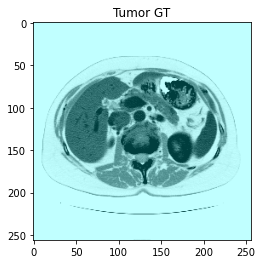

slice id: 10


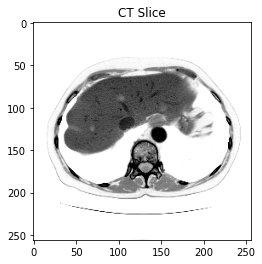

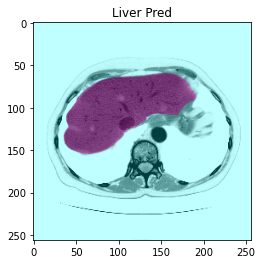

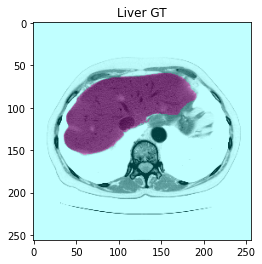

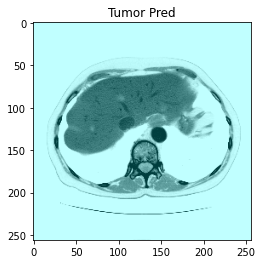

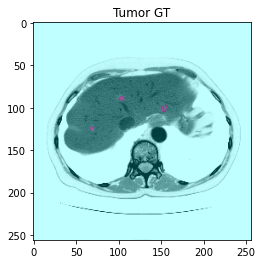

slice id: 11


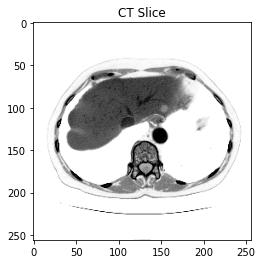

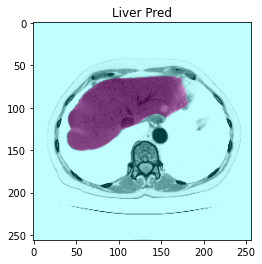

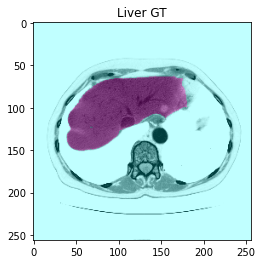

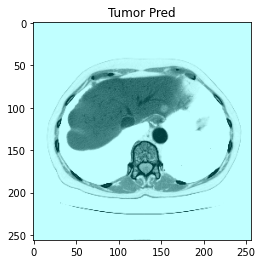

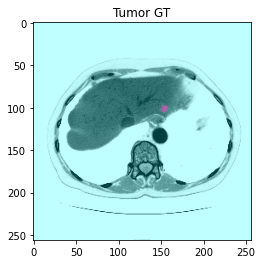

slice id: 12


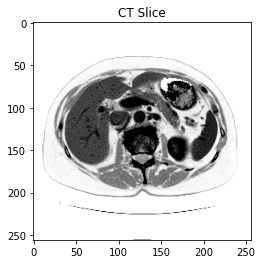

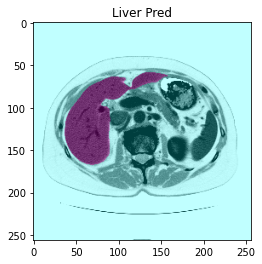

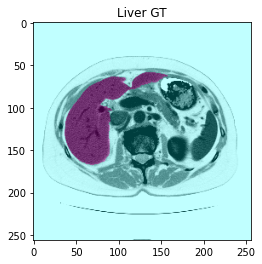

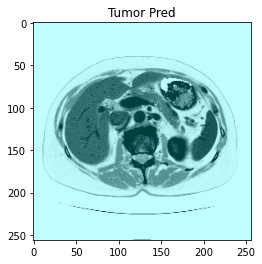

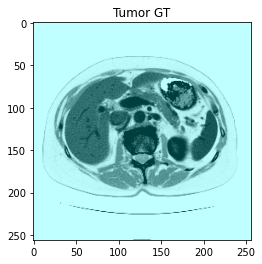

slice id: 13


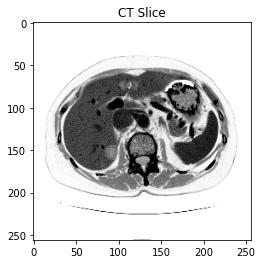

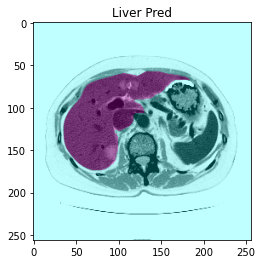

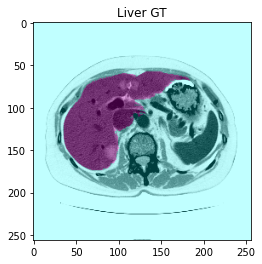

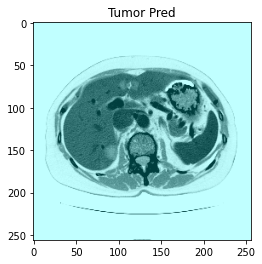

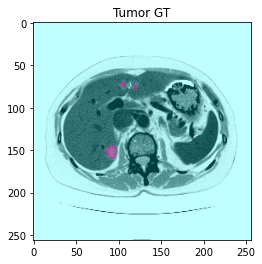

slice id: 14


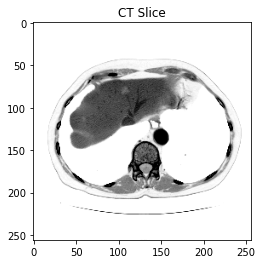

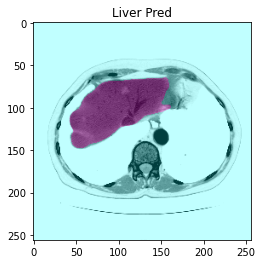

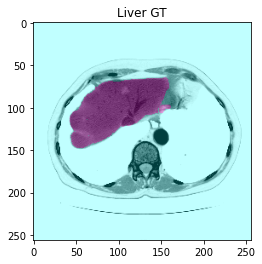

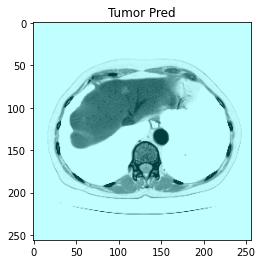

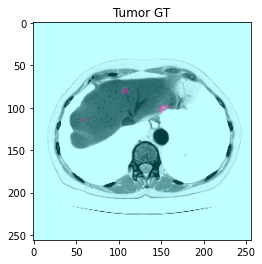

slice id: 15


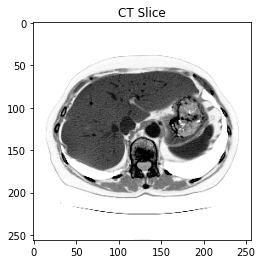

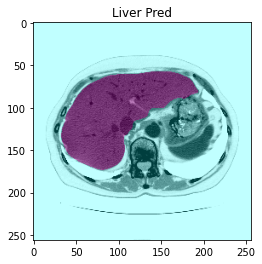

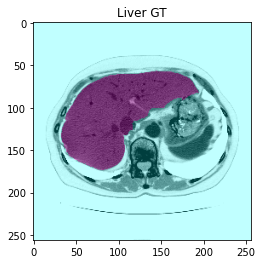

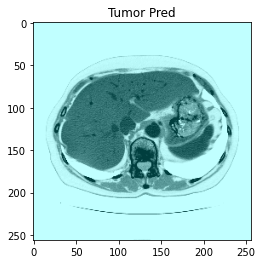

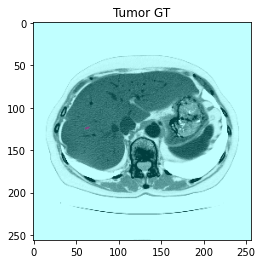

slice id: 16


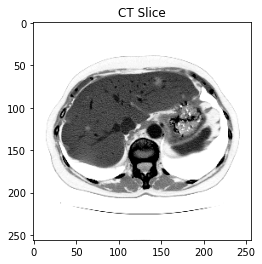

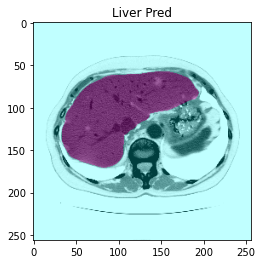

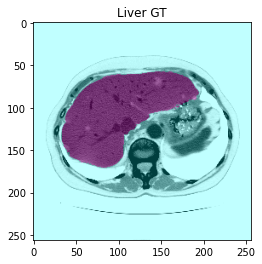

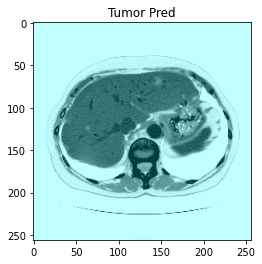

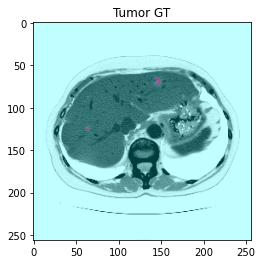

slice id: 17


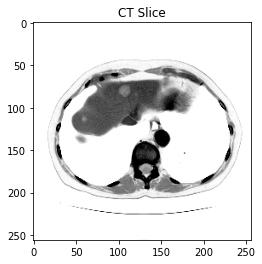

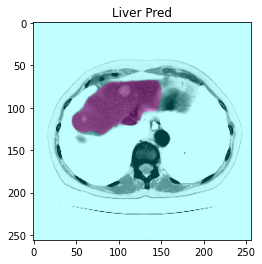

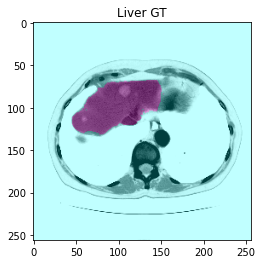

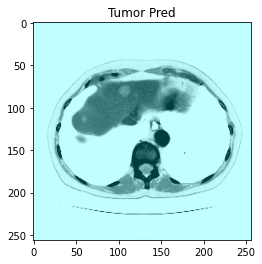

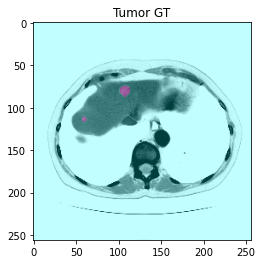

slice id: 18


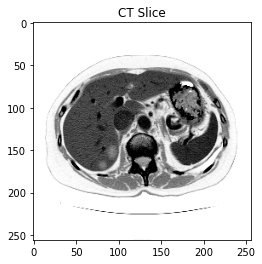

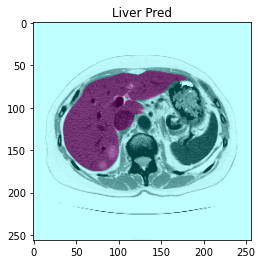

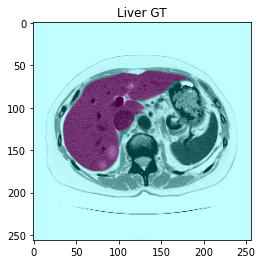

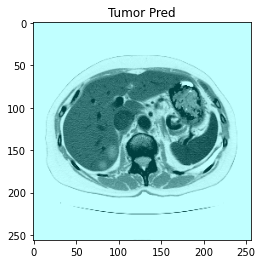

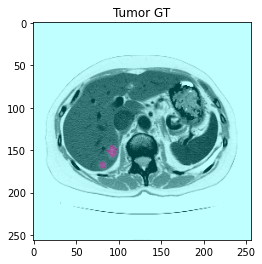

slice id: 19


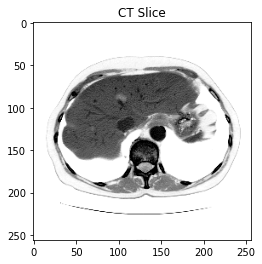

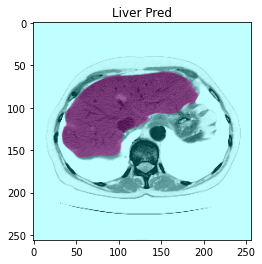

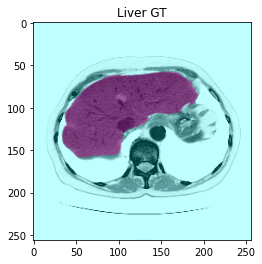

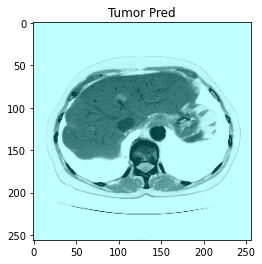

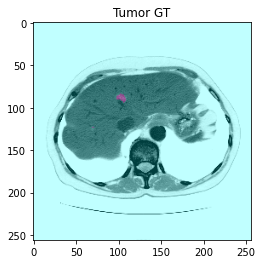

slice id: 20


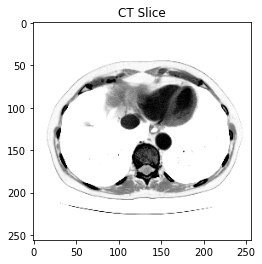

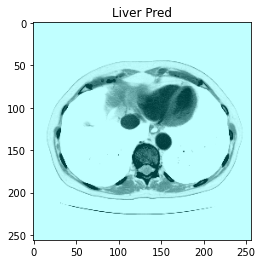

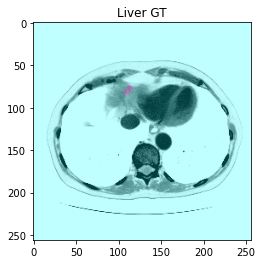

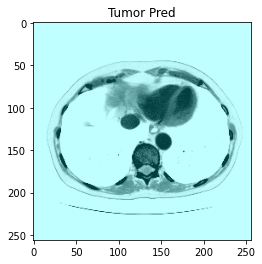

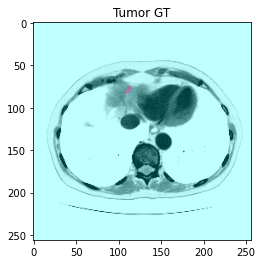

slice id: 21


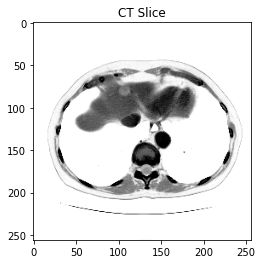

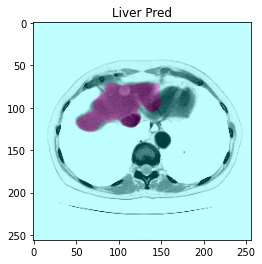

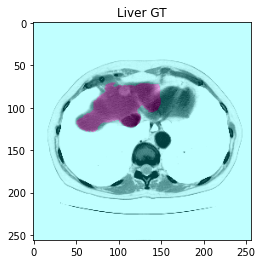

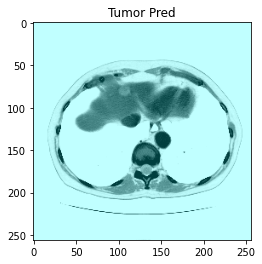

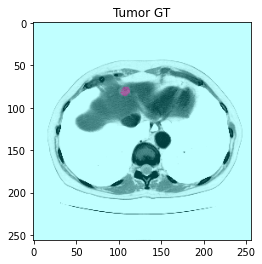

slice id: 22


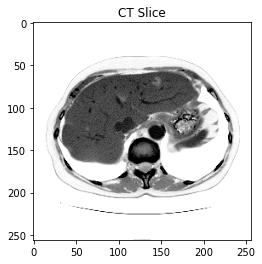

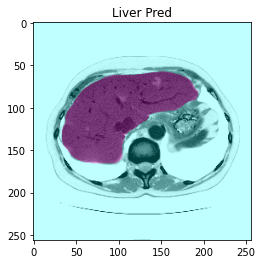

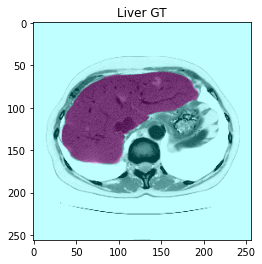

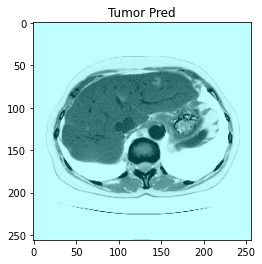

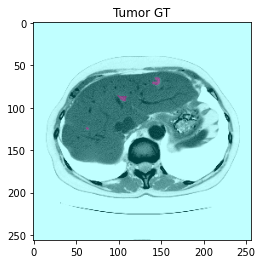

slice id: 23


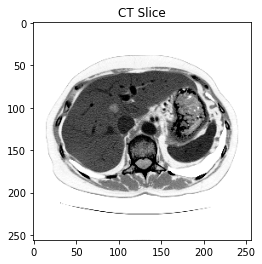

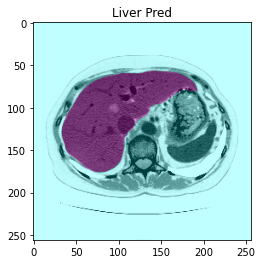

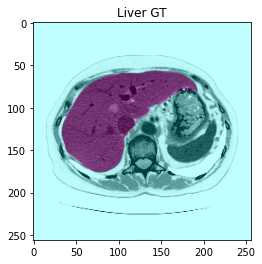

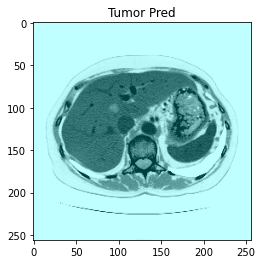

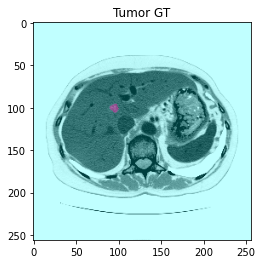

slice id: 24


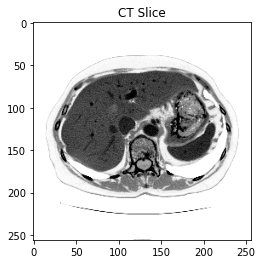

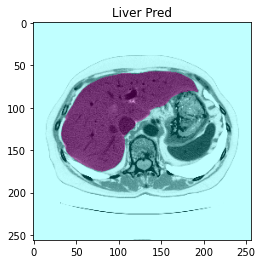

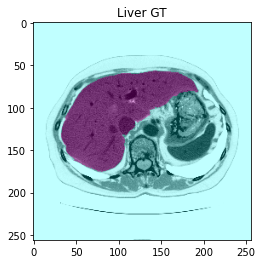

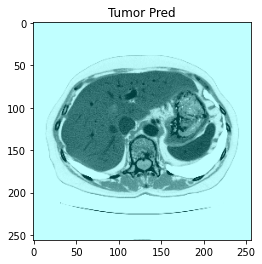

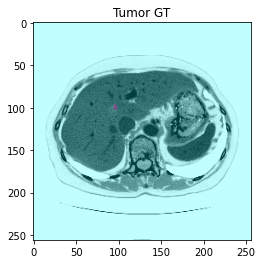

In [8]:
import matplotlib.pyplot as plt


# 1) Predict valid set
valid_pred = model.predict(valid_x)

# 2) Calculate mean dice
liver_dices = []
tumor_dices = []
for i in range(len(valid_pred)):
    liver_y = valid_y[i, :, :, 0]
    tumor_y = valid_y[i, :, :, 1]
    liver_pred = valid_pred[i, :, :, 0]
    tumor_pred = valid_pred[i, :, :, 1]
    
    liver_dice = dice_coefficient(liver_y, liver_pred)
    tumor_dice = dice_coefficient(tumor_y, tumor_pred)
    liver_dice = np.round(liver_dice, 3)
    tumor_dice = np.round(tumor_dice, 3)
    liver_dices.append(liver_dice)
    tumor_dices.append(tumor_dice)

print(f'Mean dice of liver: {np.mean(liver_dices)}')
print(f'Mean dice of tumor: {np.mean(tumor_dices)}')

# 3) Visualize pred
n_sample = 25
for i, image in enumerate(valid_x[:n_sample]):
    
    print(f'slice id: {i}')
    
    plt.title('CT Slice')
    plt.imshow(image, cmap='Greys')
    plt.show()
    
    plt.title('Liver Pred')
    plt.imshow(image, cmap='Greys')
    plt.imshow(valid_pred[i, :, :, 0], cmap='cool', alpha=0.25)
    plt.show()
    
    plt.title('Liver GT')
    plt.imshow(image, cmap='Greys')
    plt.imshow(valid_y[i, :, :, 0], cmap='cool', alpha=0.25)
    plt.show()
    
    plt.title('Tumor Pred')
    plt.imshow(image, cmap='Greys')
    plt.imshow(valid_pred[i, :, :, 1], cmap='cool', alpha=0.25)
    plt.show()
    
    plt.title('Tumor GT')
    plt.imshow(image, cmap='Greys')
    plt.imshow(valid_y[i, :, :, 1], cmap='cool', alpha=0.25)
    plt.show()
    